In [31]:
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import mnist, cifar10
from keras.models import load_model
from keras.utils.np_utils import to_categorical
import numpy as np

from art.estimators.classification import KerasClassifier
from art.utils import get_file
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from pathlib import Path
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, DeepFool, ThresholdAttack, PixelAttack, HopSkipJump, CarliniL2Method, AdversarialPatch
from sklearn.model_selection import ParameterGrid
import hashlib
import pickle
from pathlib import Path
from art.utils import compute_success, compute_accuracy
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, DeepFool, ThresholdAttack, PixelAttack, HopSkipJump, CarliniL2Method, CarliniLInfMethod, AdversarialPatch
from sklearn.model_selection import ParameterGrid
import hashlib
from tqdm.notebook import tqdm
import os

os.environ["CUDA_VISIBLE_DEVICES"]= "1,2"
tf.keras.backend.clear_session()

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

In [32]:
def run_attack_search(atk_dict, data_name, data_dict, model_dict, sample_size = 20,  param_name =None):
    i = 0
    new_results = {}
    
    for attack_name in atk_dict:
        new_results[attack_name] = new_results.get(attack_name, {})
        param_name = max(atk_dict[attack_name], key=lambda k: len(atk_dict[attack_name][k])) if param_name is None else param_name
        if attack_name not in new_results:
            new_results[attack_name] = {}
        attack_name = list(atk_dict.keys())[i]
        atk_params = list(atk_dict.values())[i]
        data = data_dict[data_name]
        model = model_dict[data_name]
        (_, _), (X_test, _) = data
        atk_grid = ParameterGrid(atk_params)
        
        for entry in tqdm(atk_grid):
            entry_without_name = entry.copy()
            entry_without_name.pop("name")
            hash_name = hashlib.md5(str(entry_without_name).encode('utf-8')).hexdigest()
            new_results[attack_name][hash_name] = new_results[attack_name].get(hash_name, {})
            if hash_name not in new_results[attack_name]:
                new_results[attack_name][hash_name] = {}
            if "params" not in new_results[attack_name][hash_name]:
                new_results[attack_name][hash_name]['params'] = entry
            name = entry.pop("name")
            attack = name(model, **entry, verbose=True)
            if "samples" in new_results[attack_name][hash_name] and new_results[attack_name][hash_name]['samples'].shape[0] == sample_size:
                print(f"Attack {name} with params {entry} already finished")
            else:
                print(f"Running attack {attack_name} with params {entry}")
                # targets = np.argmax(y_test[:sample_size], axis=1) -1
                # targets = np.array([target if target >= 0 else 9 for target in targets])
                samples = attack.generate(X_test[:sample_size])
                new_results[attack_name][hash_name]['samples'] = samples
            new_results[attack_name].update(**new_results[attack_name])
        i += 1
    return new_results

In [33]:

def plot_line_search(data, model, title, results, param_name, param_display_name, scaling_factor, result_display_name, cmap = 'gray',):
    res = results
    (X_train, y_train), (X_test, y_test) = data
    for key in res:
        title = key
        length = len(res[key])
        if length == 0:
            continue
        fig, axs = plt.subplots(1, length, figsize=(20, 5))
        i = 0
        var_param = param_name
        res[key] = {k: v for k, v in sorted(res[key].items(), key=lambda item: item[1]['params'][var_param])}
        for sub_key in res[key]:
            preds = model.predict(res[key][sub_key]['samples'])
            adv_preds = model.predict(res[key][sub_key]['samples'])
            sample = res[key][sub_key]['samples'][0]
            if data == "mnist":
                cmap = "gray"
            else:
                cmap = "hot"
            if sample.shape[-1] != 1:
                sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
            if length == 1:
                fig = axs.imshow(sample, cmap=cmap)
            else:
                fig = axs[i].imshow(sample, cmap=cmap)
            fig.set_cmap('gray')
            # fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
            print(res[key][sub_key]['params'])
            param_name = var_param
            num = res[key][sub_key]['params'][param_name] * scaling_factor
            # score = np.mean(np.subtract(preds, adv_preds))
            ben_score = compute_accuracy(preds, y_test[:len(preds)])[1]
            adv_score = 1 - compute_accuracy(adv_preds, y_test[:len(adv_preds)])[1]
            num = round(num, 2)
            adv_score = round(adv_score, 2)
            if i == 0:
                fig.axes.set_title(fr"{param_display_name} = {num}")
                fig.axes.set_xlabel(f"{result_display_name} = {adv_score}")
                fig.axes.set_xticks([])
            else:
                fig.axes.set_title(fr"{num}")
                fig.axes.set_xlabel(f"{adv_score}")
                fig.axes.set_xticks([])
            i +=1
            print(f"Benign Score: {ben_score}")
            print(f"Adversarial Score: {adv_score}")
        plt.suptitle(title, y =.70)
        plt.tight_layout()
        plt.savefig(f"{title}_{param_name}.pdf")
        plt.show()




In [34]:
### Load Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
mnist_data = (X_train, y_train), (X_test, y_test)

### Load Model
path = "mnist/model.h5"
if not Path(path).exists():
    path = get_file(path,extract=False, path=".",
                    url='https://www.dropbox.com/s/bv1xwjaf1ov4u7y/mnist_ratio%3D0.h5?dl=1')
    model = load_model(path)
    mnist_clf = KerasClassifier(model=model, use_logits=False, clip_values=[0,1])
else:
    model = load_model(path)
    mnist_clf = KerasClassifier(model=model, use_logits=False, clip_values=[0,1])

data_dict = {"mnist": mnist_data}
model_dict = {"mnist": mnist_clf}
results = {}

INFO:art.estimators.classification.keras:Inferred 90 hidden layers on Keras classifier.


{'batch_size': 1, 'confidence': 0, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 1, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 2, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 4, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 8, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 16, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0


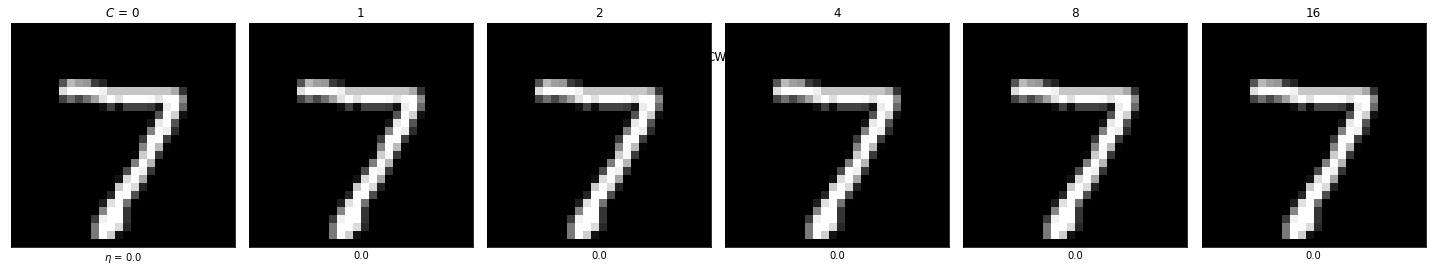

In [36]:
sample_size = 1
atk_dict = {"CW" : {"name" : [CarliniL2Method], "confidence" : [0, 1, 2, 4, 8, 16], "batch_size" :[sample_size], "max_iter" : [10], "initial_const" : [10], "learning_rate" : [.1]}}
# if "results" not in locals():
#     
results1 = run_attack_search(atk_dict, data_dict = data_dict, model_dict = model_dict, data_name="mnist", sample_size = sample_size)
param_name = max(atk_dict['CW'], key=lambda k: len(atk_dict['CW'][k]))
param_display_name = "$C$"
scaling_factor = 1
result_display_name = "$\eta$"
attack_name = "CW"
formal_atk_name = "Carlini-Wagner"
data_name = "Mnist"
title = f"{formal_atk_name} attack on data {data_name} with {sample_size} samples per attack and {len(results1[attack_name])} variations of parameter: {param_name}"
filename = plot_line_search(data=mnist_data, model=mnist_clf, title=title, results=results1, param_name=param_name, param_display_name=param_display_name, scaling_factor=scaling_factor, result_display_name=result_display_name, cmap = 'gray')


  0%|          | 0/5 [00:00<?, ?it/s]

Running attack CW with params {'batch_size': 1, 'confidence': 0, 'initial_const': 1, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 0.00%


Running attack CW with params {'batch_size': 1, 'confidence': 0, 'initial_const': 10, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 0.00%


Running attack CW with params {'batch_size': 1, 'confidence': 0, 'initial_const': 100, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 0.00%


Running attack CW with params {'batch_size': 1, 'confidence': 0, 'initial_const': 1000, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 0.00%


Running attack CW with params {'batch_size': 1, 'confidence': 0, 'initial_const': 10000, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 0.00%


{'batch_size': 1, 'confidence': 0, 'initial_const': 1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 0, 'initial_const': 10, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 0, 'initial_const': 100, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 0, 'initial_const': 1000, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 0, 'initial_const': 10000, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0


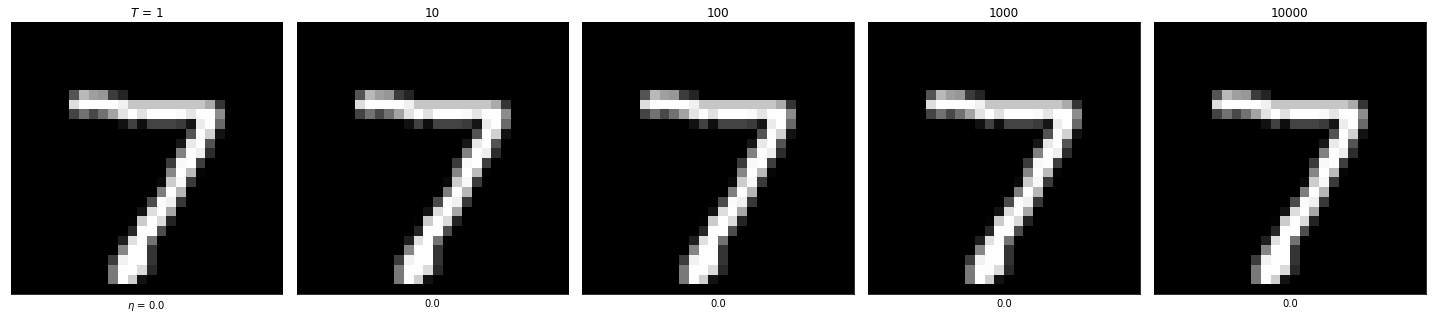

In [37]:
sample_size = 1
atk_dict = {"CW" : {"name" : [CarliniL2Method], "confidence" : [0], "batch_size" :[sample_size], "max_iter" : [10], "initial_const" : [1, 10, 100, 1000, 10000]}}
# if "results" not in locals():
#     
results2 = run_attack_search(atk_dict, data_dict = data_dict, model_dict = model_dict, data_name="mnist", sample_size = sample_size)
param_name = max(atk_dict['CW'], key=lambda k: len(atk_dict['CW'][k]))
param_display_name = "$T$"
scaling_factor = 1
result_display_name = "$\eta$"
attack_name = "CW"
formal_atk_name = "Carlini-Wagner"
data_name = "MNIST"
title = f"{formal_atk_name} attack on data {data_name} with {sample_size} samples per attack and {len(results2[attack_name])} variations of parameter: {param_name}"
filename = plot_line_search(data=mnist_data, model=mnist_clf, title=title, results=results2, param_name=param_name, param_display_name=param_display_name, scaling_factor=scaling_factor, result_display_name=result_display_name, cmap = 'gray')


{'batch_size': 1, 'confidence': 0, 'initial_const': 1, 'max_iter': 1}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 0, 'initial_const': 1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 0, 'initial_const': 1, 'max_iter': 100}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 1, 'confidence': 0, 'initial_const': 1, 'max_iter': 1000}
Benign Score: 1.0
Adversarial Score: 0.0


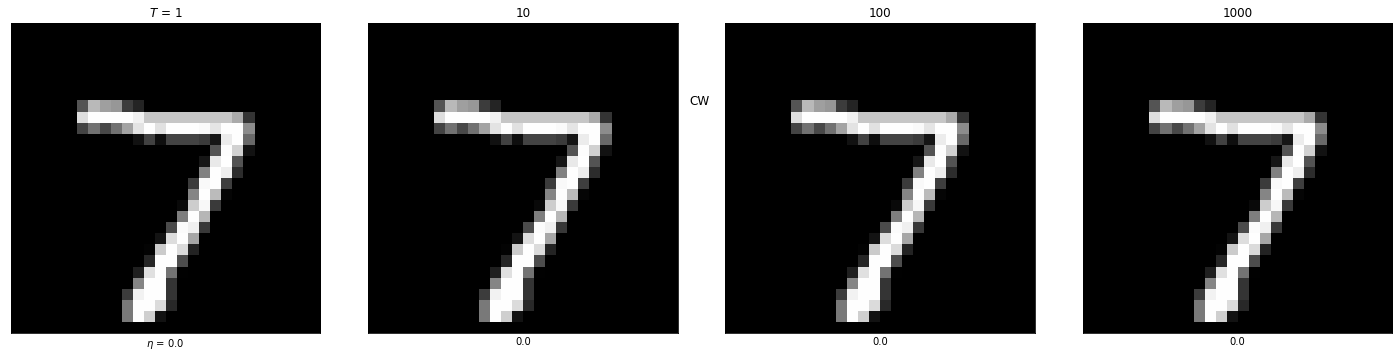

In [39]:
sample_size = 20
atk_dict = {"CW" : {"name" : [CarliniL2Method], "confidence" : [0], "batch_size" :[1], "max_iter" : [1, 10, 100, 1000], "initial_const" : [1]}}
# if "results" not in locals():
#     
# results2 = run_attack_search(atk_dict, data_dict = data_dict, model_dict = model_dict, data_name="mnist", sample_size = sample_size)
# param_name = max(atk_dict, key=lambda k: len(atk_dict[k]))
param_name = "max_iter"
param_display_name = "$T$"
scaling_factor = 1
result_display_name = "$\eta$"
attack_name = "CW"
formal_atk_name = "Carlini-Wagner"
data_name = "MNIST"
title = f"{formal_atk_name} attack on data {data_name} with {sample_size} samples per attack and {len(results2[attack_name])} variations of parameter: {param_name}"
filename = plot_line_search(data=mnist_data, model=mnist_clf, title=title, results=results2, param_name=param_name, param_display_name=param_display_name, scaling_factor=scaling_factor, result_display_name=result_display_name, cmap = 'gray')


  0%|          | 0/4 [00:00<?, ?it/s]

Running attack CW with params {'batch_size': 20, 'confidence': 0, 'initial_const': 1, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 5.00%


Running attack CW with params {'batch_size': 20, 'confidence': 0, 'initial_const': 10, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 5.00%


Running attack CW with params {'batch_size': 20, 'confidence': 0, 'initial_const': 100, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 10.00%


Running attack CW with params {'batch_size': 20, 'confidence': 0, 'initial_const': 1000, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 10.00%


{'batch_size': 20, 'confidence': 0, 'initial_const': 1, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 20, 'confidence': 0, 'initial_const': 10, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 20, 'confidence': 0, 'initial_const': 100, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 20, 'confidence': 0, 'initial_const': 1000, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0


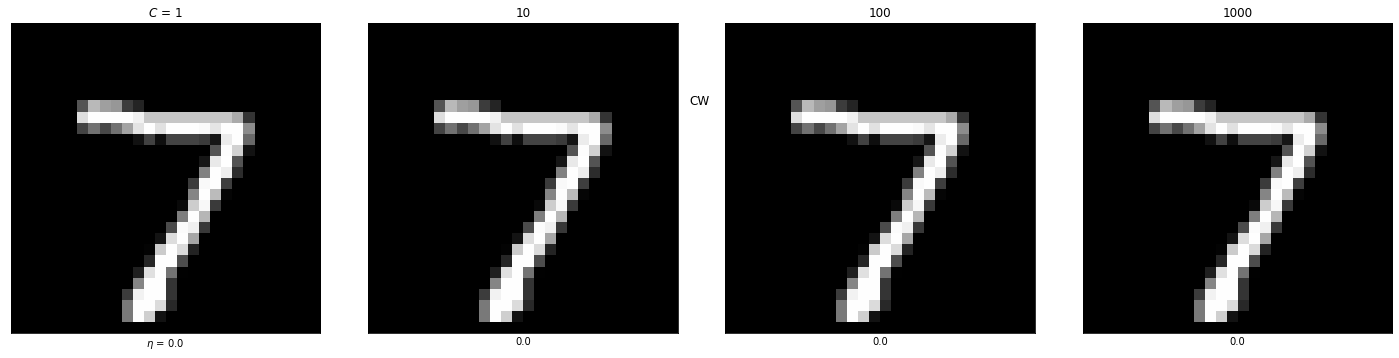

In [40]:
sample_size = 20
atk_dict = {"CW" : {"name" : [CarliniL2Method], "confidence" : [0], "batch_size" :[sample_size], "max_iter" : [10], "initial_const" : [1, 10, 100, 1000]}}
# if "results" not in locals():
#     
results3 = run_attack_search(atk_dict, data_dict = data_dict, model_dict = model_dict, data_name="mnist", sample_size = sample_size)
# param_name = max(atk_dict, key=lambda k: len(atk_dict[k]))
param_name = "initial_const"
param_display_name = "$C$"
scaling_factor = 1
result_display_name = "$\eta$"
attack_name = "CW"
formal_atk_name = "Carlini-Wagner"
data_name = "MNIST"
title = f"{formal_atk_name} attack on data {data_name} with {sample_size} samples per attack and {len(results3[attack_name])} variations of parameter: {param_name}"
filename = plot_line_search(data=mnist_data, model=mnist_clf, title=title, results=results3, param_name=param_name, param_display_name=param_display_name, scaling_factor=scaling_factor, result_display_name=result_display_name, cmap = 'gray')


  0%|          | 0/4 [00:00<?, ?it/s]

Running attack CW with params {'batch_size': 20, 'binary_search_steps': 1, 'confidence': 0, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 0.00%


Running attack CW with params {'batch_size': 20, 'binary_search_steps': 10, 'confidence': 0, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 5.00%


Running attack CW with params {'batch_size': 20, 'binary_search_steps': 100, 'confidence': 0, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 20.00%


Running attack CW with params {'batch_size': 20, 'binary_search_steps': 1000, 'confidence': 0, 'max_iter': 10}


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:art.attacks.evasion.carlini:Success rate of C&W L_2 attack: 20.00%


{'batch_size': 20, 'binary_search_steps': 1, 'confidence': 0, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 20, 'binary_search_steps': 10, 'confidence': 0, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 20, 'binary_search_steps': 100, 'confidence': 0, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0
{'batch_size': 20, 'binary_search_steps': 1000, 'confidence': 0, 'max_iter': 10}
Benign Score: 1.0
Adversarial Score: 0.0


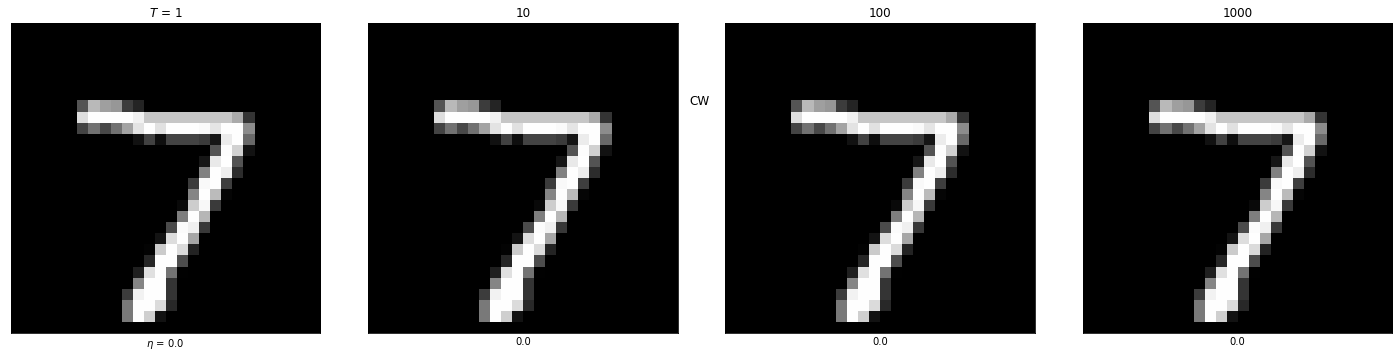

In [41]:
sample_size = 20
atk_dict = {"CW" : {"name" : [CarliniL2Method], "confidence" : [0], "batch_size" :[sample_size], "max_iter" : [10], "binary_search_steps" : [1, 10, 100, 1000]}}
# if "results" not in locals():
#     
results4 = run_attack_search(atk_dict, data_dict = data_dict, model_dict = model_dict, data_name="mnist", sample_size = sample_size)
param_name = max(atk_dict["CW"], key=lambda k: len(atk_dict["CW"][k]))
param_display_name = "$T$"
scaling_factor = 1
result_display_name = "$\eta$"
attack_name = "CW"
formal_atk_name = "Carlini-Wagner"
data_name = "MNIST"
title = f"{formal_atk_name} attack on data {data_name} with {sample_size} samples per attack and {len(results4[attack_name])} variations of parameter: {param_name}"
filename = plot_line_search(data=mnist_data, model=mnist_clf, title=title, results=results4, param_name=param_name, param_display_name=param_display_name, scaling_factor=scaling_factor, result_display_name=result_display_name, cmap = 'gray')


Number of samples that were misclassified: 0
Shape of samples: (1, 28, 28, 1)
Shape of notequal: (0,)
####################################
##      []      ##
####################################
No good samples found
Params : {'batch_size': 1, 'confidence': 0, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Number of samples that were misclassified: 0
Shape of samples: (1, 28, 28, 1)
Shape of notequal: (0,)
####################################
##      []      ##
####################################
No good samples found
Params : {'batch_size': 1, 'confidence': 1, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Number of samples that were misclassified: 0
Shape of samples: (1, 28, 28, 1)
Shape of notequal: (0,)
####################################
##      []      ##
####################################
No good samples found
Params : {'batch_size': 1, 'confidence': 2, 'initial_const': 10, 'learning_rate': 0.1, 'max_iter': 10}
Number of samples that were misclassifie

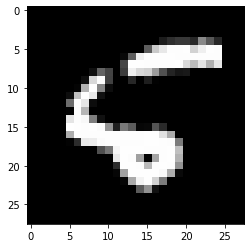

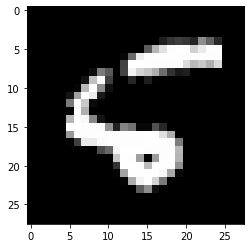

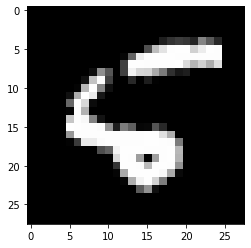

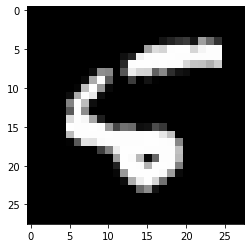

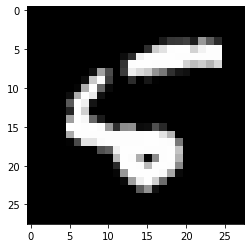

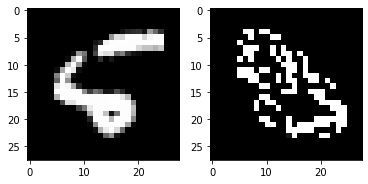

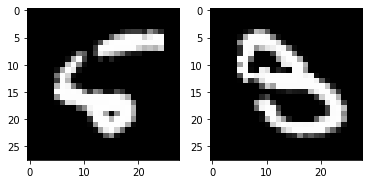

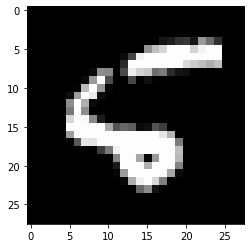

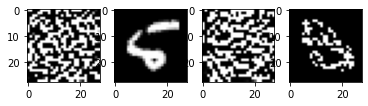

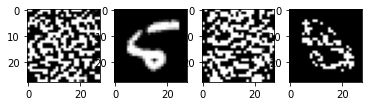

In [94]:
# new_results = {**results1, **results2, **results3, **results4}
new_results = {}
new_results['CW'] = {**results1['CW'], **results2['CW'], **results3['CW'], **results4['CW']}
import pandas as pd
big_df = pd.DataFrame()
good_sample = {}
(X_train, y_train), (X_test, y_test) = data_dict['mnist']
for result in new_results['CW']:
    params = new_results['CW'][result]['params']
    samples = new_results['CW'][result]['samples']
    ser = pd.Series()
    ser['id'] = result
    ser['samples'] = samples
    ser['params'] = (params)
    preds = mnist_clf.predict(samples)
    preds = np.argmax(preds, axis=1)
    y_cat = np.argmax(y_test, axis=1)[:samples.shape[0]]
    notequal = np.where(preds != y_cat)
    print(f"Number of samples that were misclassified: {len(notequal[0])}")
    print(f"Shape of samples: {samples.shape}")
    print(f"Shape of notequal: {notequal[0].shape}")
    print("####################################")
    print(f"##      {notequal[0]}      ##")
    print("####################################")
    i = 0
    if len(notequal[0]) > 0:
        fig, axs = plt.subplots(1, len(notequal[0]))
        for good_sample_idx in notequal[0]:
            print(good_sample_idx)
            if len(notequal[0]) == 1:
                graph = axs.imshow(samples[good_sample_idx].reshape(28, 28), cmap='gray')
            else:
                graph = axs[i].imshow(samples[good_sample_idx].reshape(28, 28), cmap='gray')
            
            i += 1
        print(f"Predicted class: {preds[good_sample_idx]}")
        print(f"Actual class: {y_cat[good_sample_idx]}")
        print(f"Params : {params}")
    else:
        print("No good samples found")
        print(f"Params : {params}")
    
    
